In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression

def db_cleaner(db,i) :
    #Elimino eventuali dati impossibili
    db = db[(db["Air temperature [K]"] > 1) | (db['Process temperature [K]'] > 1) | (db["Tool wear [min]"] > 0) | (db["Torque [Nm]"] > 0)]
    
    if(i==1) :
        #Elimino i missmatch tra colonna failure e failure type
        df_failure = db[db['Failure'] == 1]
        index_possible_failure = df_failure[df_failure['Failure Type'] == 'No Failure'].index
        db.drop(index_possible_failure, axis=0, inplace=True)

        df_failure = db[db['Failure'] == 0]
        index_possible_failure = df_failure[df_failure['Failure Type'] == 'Random Failures'].index
        db.drop(index_possible_failure, axis=0, inplace=True)
    

    #Elimino le colonne UDI e Product ID
    db = db.drop(["UDI","Product ID"],axis = 1)

    #Faccio l'encoding dei parametri Type e Failure Type
    mapper = {'L' : 0, 'M' : 1, 'H' : 2}
    db['Type'].replace(mapper, inplace=True)
    
    return db

def db_scaler(db) :
    columnsR = ['Rotational speed [rpm]', 'Torque [Nm]']
    columnsM = ['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]']
    scalerR = RobustScaler()
    scalerM = MinMaxScaler()
    features_scaledR = scalerR.fit_transform(db[columnsR])
    features_scaledR = pd.DataFrame(features_scaledR, columns=columnsR)
    features_scaledM = scalerM.fit_transform(db[columnsM])
    features_scaledM = pd.DataFrame(features_scaledM, columns=columnsM)
    db1 = pd.concat([features_scaledM,features_scaledR,db[["Failure","Failure Type"]]], axis=1)

    db1 = db1.dropna()
    
    return db1

def xy_splitter(db) :
    db_x = db.drop(columns=["Failure","Failure Type"], axis = 1)
    db_y = db["Failure"].astype(int)

    return db_x,db_y

def db_smote(x_db,y_db,ratio) :
    smote = SMOTE(random_state=0,sampling_strategy=ratio)
    x_smote,y_smote = smote.fit_resample(x_db,y_db)

    return x_smote,y_smote


In [129]:
df_train = pd.read_csv("https://raw.githubusercontent.com/Piovesale/Data-Projects/main/Failure_Classfication/predictive_maIntenance_train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/Piovesale/Data-Projects/main/Failure_Classfication/predictive_maIntenance_test.csv")

df_train = db_cleaner(df_train,0)
df_test = db_cleaner(df_test,0)


([<matplotlib.axis.XTick at 0x1c13de767a0>,
 [Text(0.25, 0, 'No Failure'), Text(0.75, 0, 'Failure')])

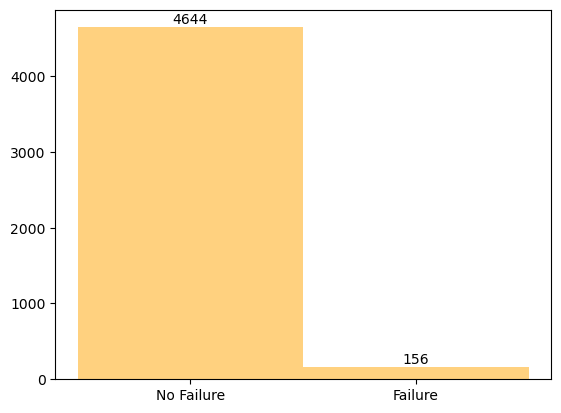

In [130]:
# Visualizzo la distribuzione di failure
n, bins, patches = plt.hist(df_train["Failure"].astype(int), bins=2, color='orange', alpha=0.5, align='mid')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2., patches[i].get_height()+5, int(n[i]), ha='center', va='bottom')
plt.xticks([0.25, 0.75], ['No Failure', 'Failure'])

In [131]:
## sns.pairplot(df_train, hue='Failure Type', palette='husl', vars =["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"])

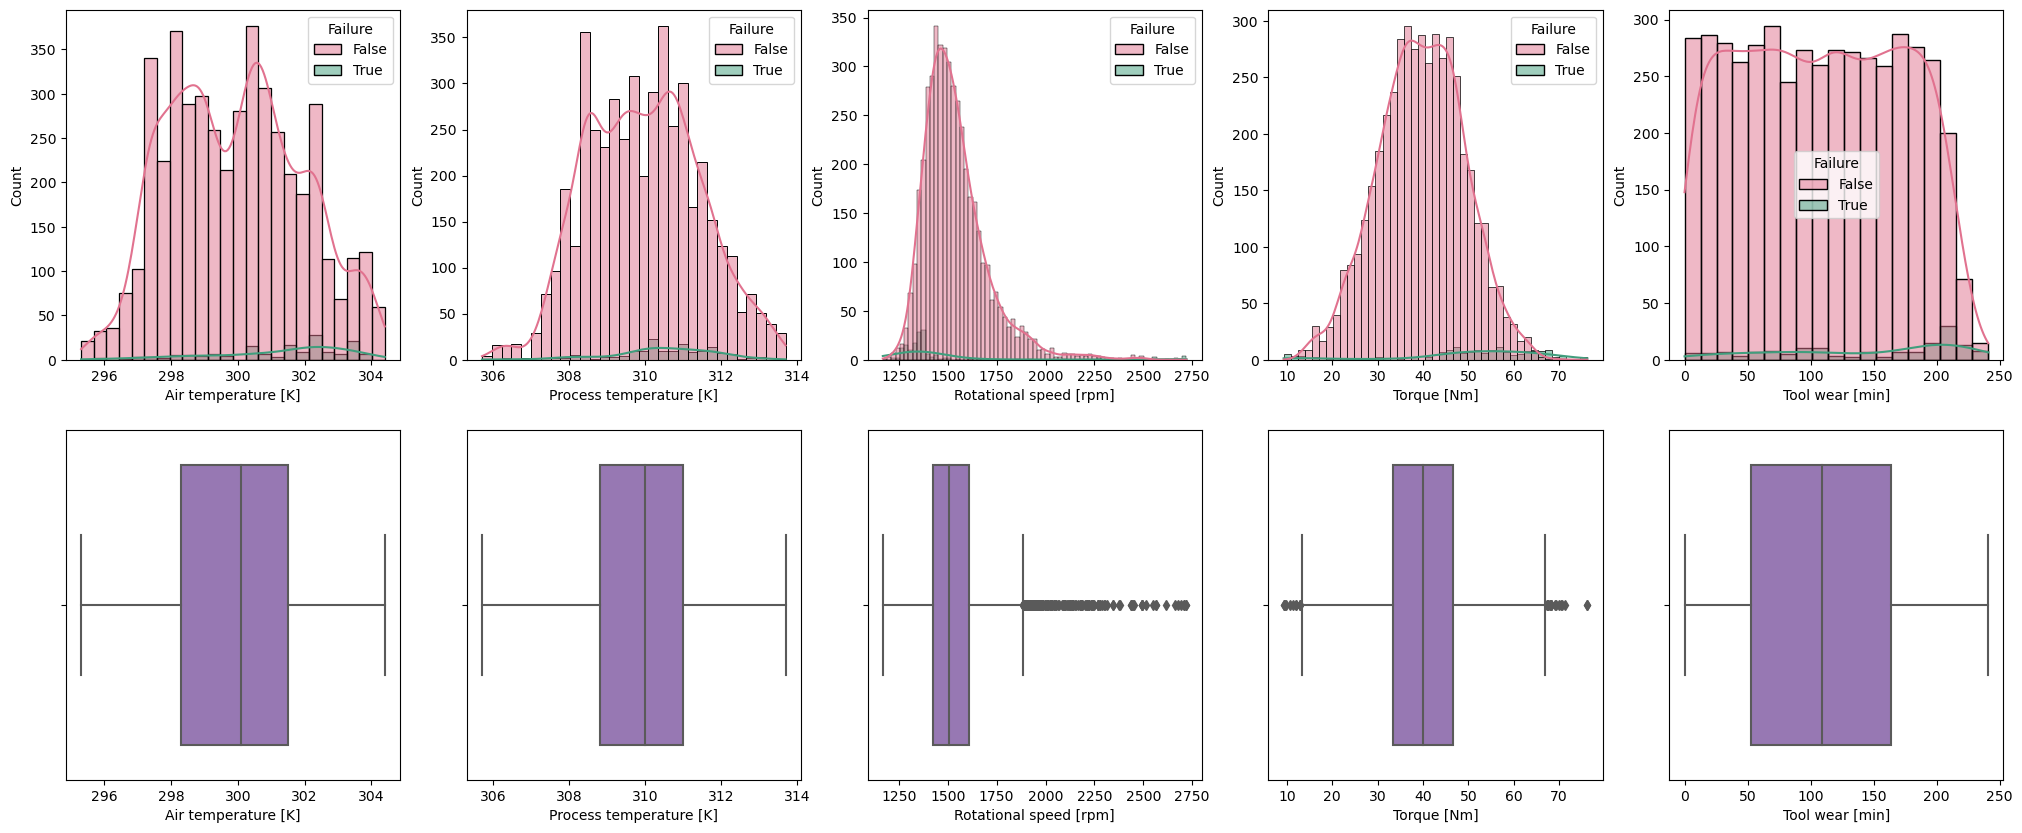

In [132]:
#controllo con boxplot se sono presenti outliers 
fig, axes = plt.subplots(2, 5, figsize=[25,10])
j = 0
colors = ['#E1728F', '#409E7D']

for i in ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']:
    sns.histplot(data=df_train, x=i, kde=True, ax=axes[0,j], hue='Failure', palette=colors)
    sns.boxplot(data=df_train, x=i, ax=axes[1,j], palette=['#976EBD'])
    j+=1

Dai boxplot si vede che rotational speed e torque presentano outliers, provo a scalarli usando robust scaler che viene influenzato meno dalla loro presenza

In [133]:
df_train_scaled = db_scaler(df_train)
df_test_scaled = db_scaler(df_test)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train.describe()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,4800.000,4800.000,4800.000,4800.000,4800.000,4800.000
mean,0.516,299.980,309.977,1536.170,40.021,108.738
std,0.677,1.991,1.476,175.244,9.875,63.900
min,0.000,295.300,305.700,1168.000,9.300,0.000
25%,0.000,298.300,308.800,1423.000,33.300,53.000
50%,0.000,300.100,310.000,1504.000,40.100,109.000
75%,1.000,301.500,311.000,1608.000,46.700,164.000
max,2.000,304.400,313.700,2721.000,76.200,241.000


### Classificazione
Possiamo fare prova generale su database non oversampled per vedere se fare la feature selection abbia senso, ci aspettiamo che essendo un numero molto limitato possano essere tenute tutte senza impattare nelle prestazioni
#### 1. Random Forest

In [134]:
def db_randomforest(x_db_train,y_db_train,x_db_test) :
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(x_db_train,y_db_train)
    y_db_pred_randomforest = clf.predict(x_db_test)
    return y_db_pred_randomforest

print("#### RISULTATI RANDOM FOREST SENZA SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_test, y_test = xy_splitter(df_test)
y_pred = db_randomforest(x_train,y_train,x_test)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST CON SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_randomforest(x_train,y_train,x_test)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST SENZA SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_train, y_train = db_smote(x_train,y_train,0.1)
x_test, y_test = xy_splitter(df_test)
y_pred = db_randomforest(x_train,y_train,x_test)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST CON SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_train, y_train = db_smote(x_train,y_train,0.1)
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_randomforest(x_train,y_train,x_test)
print(classification_report(y_test,y_pred))

"""
import pydot

estimator = clf.estimators_[5]
export_graphviz(estimator, out_file = 'ros_tree.dot', rounded = True, proportion = False, precision = 2, filled = True, leaves_parallel= False,feature_names = x_df_train_scaled.columns.values, class_names=['No Failure','Failure'])

(graph,) = pydot.graph_from_dot_file('ros_tree.dot')
graph.write_png('ros_tree.png')

from IPython.display import Image
Image(filename = 'ros_tree.png')
"""

#### RISULTATI RANDOM FOREST SENZA SCALING SENZA SMOTE ####
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       712
           1       1.00      0.42      0.59        31

    accuracy                           0.98       743
   macro avg       0.99      0.71      0.79       743
weighted avg       0.98      0.98      0.97       743

#### RISULTATI RANDOM FOREST CON SCALING SENZA SMOTE ####
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       712
           1       0.81      0.55      0.65        31

    accuracy                           0.98       743
   macro avg       0.90      0.77      0.82       743
weighted avg       0.97      0.98      0.97       743

#### RISULTATI RANDOM FOREST SENZA SCALING CON SMOTE ####
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       712
           1       0.79      0.61      0.69        31

    ac

"\nimport pydot\n\nestimator = clf.estimators_[5]\nexport_graphviz(estimator, out_file = 'ros_tree.dot', rounded = True, proportion = False, precision = 2, filled = True, leaves_parallel= False,feature_names = x_df_train_scaled.columns.values, class_names=['No Failure','Failure'])\n\n(graph,) = pydot.graph_from_dot_file('ros_tree.dot')\ngraph.write_png('ros_tree.png')\n\nfrom IPython.display import Image\nImage(filename = 'ros_tree.png')\n"

#### 2 SVM

In [135]:
# Definisci i parametri da esplorare nella ricerca della griglia
parameters = {
    'C': [0.1, 1, 10],                      #per binarie sbilanciate utilizzare valori piccoli
    'kernel': ['sigmoid', 'rbf'], #'poly'    #solitamente rbf, sigmoid o polynomial in binarie sbilanciate
    'gamma': ['scale', 'auto']
}


def db_svm(x_db_train,y_db_train,x_db_test,scorer) :
    _svc = svm.SVC()
    _scoring = make_scorer(scorer, pos_label=1)
    grid_search_svc = GridSearchCV(_svc, parameters, scoring=_scoring, cv=5)
    grid_search_svc.fit(x_db_train,y_db_train)
    print("Migliori parametri per ",scorer.__name__ , " : ",grid_search_svc.best_params_)
    y_db_pred = grid_search_svc.predict(x_db_test)
    return y_db_pred

print("#### RISULTATI SVM SENZA SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_test, y_test = xy_splitter(df_test)
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST CON SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST SENZA SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_train, y_train = db_smote(x_train,y_train,0.1)
x_test, y_test = xy_splitter(df_test)
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST CON SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_train, y_train = db_smote(x_train,y_train,0.1)
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

#### RISULTATI SVM SENZA SCALING SENZA SMOTE ####
Migliori parametri per  f1_score  :  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


c:\Users\alexp\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alexp\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alexp\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       712
           1       0.00      0.00      0.00        31

    accuracy                           0.96       743
   macro avg       0.48      0.50      0.49       743
weighted avg       0.92      0.96      0.94       743

#### RISULTATI RANDOM FOREST CON SCALING SENZA SMOTE ####
Migliori parametri per  f1_score  :  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       712
           1       1.00      0.16      0.28        31

    accuracy                           0.97       743
   macro avg       0.98      0.58      0.63       743
weighted avg       0.97      0.97      0.95       743

#### RISULTATI RANDOM FOREST SENZA SCALING CON SMOTE ####
Migliori parametri per  f1_score  :  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


c:\Users\alexp\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alexp\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alexp\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       712
           1       0.00      0.00      0.00        31

    accuracy                           0.96       743
   macro avg       0.48      0.50      0.49       743
weighted avg       0.92      0.96      0.94       743

#### RISULTATI RANDOM FOREST CON SCALING CON SMOTE ####
Migliori parametri per  f1_score  :  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       712
           1       0.61      0.55      0.58        31

    accuracy                           0.97       743
   macro avg       0.79      0.77      0.78       743
weighted avg       0.96      0.97      0.97       743



In [136]:
# Definisci i parametri da esplorare nella ricerca della griglia
parameters = {
    'C': [0.1, 1, 10],                      #per binarie sbilanciate utilizzare valori piccoli
    'kernel': ['sigmoid', 'rbf'], #'poly'    #solitamente rbf, sigmoid o polynomial in binarie sbilanciate
    'gamma': ['scale', 'auto']
}

#Funzione che
def db_svm(x_db_train,y_db_train,x_db_test,scorer) :
    _svc = svm.SVC()
    _scoring = make_scorer(scorer, pos_label=1)
    grid_search_svc = GridSearchCV(_svc, parameters, scoring=_scoring, cv=5)
    grid_search_svc.fit(x_db_train,y_db_train)
    print("Migliori parametri per ",scorer.__name__ , " : ",grid_search_svc.best_params_)
    y_db_pred = grid_search_svc.predict(x_db_test)
    return y_db_pred

print("#### RISULTATI SVM SENZA SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_test, y_test = xy_splitter(df_test)
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST CON SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST SENZA SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_train, y_train = db_smote(x_train,y_train,0.1)
x_test, y_test = xy_splitter(df_test)
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST CON SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_train, y_train = db_smote(x_train,y_train,0.1)
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

#### RISULTATI SVM SENZA SCALING SENZA SMOTE ####
Migliori parametri per  f1_score  :  {'C': 5, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       712
           1       1.00      0.13      0.23        31

    accuracy                           0.96       743
   macro avg       0.98      0.56      0.60       743
weighted avg       0.96      0.96      0.95       743

#### RISULTATI RANDOM FOREST CON SCALING SENZA SMOTE ####
Migliori parametri per  f1_score  :  {'C': 5, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       712
           1       1.00      0.13      0.23        31

    accuracy                           0.96       743
   macro avg       0.98      0.56      0.60       743
weighted avg       0.96      0.96      0.95       743

#### RISULTATI RANDOM FOREST SENZA SCALING CON SMOTE ####


c:\Users\alexp\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\alexp\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Migliori parametri per  f1_score  :  {'C': 5, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       712
           1       0.69      0.35      0.47        31

    accuracy                           0.97       743
   macro avg       0.83      0.67      0.73       743
weighted avg       0.96      0.97      0.96       743

#### RISULTATI RANDOM FOREST CON SCALING CON SMOTE ####
Migliori parametri per  f1_score  :  {'C': 5, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       712
           1       0.55      0.35      0.43        31

    accuracy                           0.96       743
   macro avg       0.76      0.67      0.71       743
weighted avg       0.95      0.96      0.96       743

